In [69]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 

In [70]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D

In [71]:
#opening a file to store data
f = open("phi_star_data.txt","w+") 

In [72]:
#making the nodes interact and hence transfering doses

@jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,d,p,glist,partner) :
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
#         connec_neigh_list = glist
        glist_temp = glist
#         g_array = np.array(glist_temp[n],dtype = np.int32)
        partner[n,k] = np.random.choice(g_array[n])
#         print("partner=",partner[n,k])
        z1 = np.random.uniform(0,1)

        #if one is infected and the other is susceptible and they are connected
#         print(adj_mat)
#         print(adj_mat[n,partner[n,k]])
        if (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
#         if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
                d[partner[n,k],k] = 0 #the other receives no dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
                d[partner[n,k],k] = 0
        #if both are infected and they are connected
        elif (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
#         elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
                d[partner[n,k],k] = 0 #the one STILL receives NO DOSE
            else :
#                 'interaction but no dose'
                d[n,k] = 0
                d[partner[n,k],k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
                d[partner[n,k],k] = 0
        
#         print(type(partner))
    return d,partner

In [73]:
#updating the cumulative dose distribution

@jit(nopython=True)
def upd_cumu(k,mem_time_steps,d,d_ini) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
    D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,1:((mem_time_steps-(k-m)))+1:1],1)
    
    return D

In [74]:
#updating the states of the nodes

@jit(nopython=True)
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star[n,0]) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star[n,0]) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform(0,1)
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform(0,1)
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

    phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     kount = kount + 1

    return phi, indi_state

In [75]:
#creating the static Watts-Strogatz network

# @jit(nopython=True)
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
    #getting a two dimensional list of connected nodes
    glist = []
    for row in range(N):
        # give each new row an empty list
        glist.append([])
        gglist = list(G.neighbors(row))
        glist[row].extend(gglist)
    
    return G, adj_mat, glist 
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

p= 0.0
start= 0.0
p_rew= 0.0
<class 'numpy.ndarray'>
(10, 10)
[[1, 9, 2, 8, 3, 7], [0, 2, 3, 9, 4, 8], [1, 3, 0, 4, 5, 9], [2, 4, 1, 5, 0, 6], [3, 5, 2, 6, 1, 7], [4, 6, 3, 7, 2, 8], [5, 7, 4, 8, 3, 9], [6, 8, 5, 9, 4, 0], [7, 9, 6, 0, 5, 1], [8, 0, 7, 1, 6, 2]]


/home/aiyappa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<class 'type'>) with argument(s) of type(s): (array(int32, 2d, C))
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<class 'type'>)[0m
[0m[1m[2] During: typing of call at <ipython-input-72-182dcf9fec2e> (43)
[0m
[1m
File "<ipython-input-72-182dcf9fec2e>", line 43:[0m
[1mdef interaction(N,k,adj_mat,indi_state,d,p,glist,partner) :
    <source elided>
        
[1m        print(type(partner))
[0m        [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


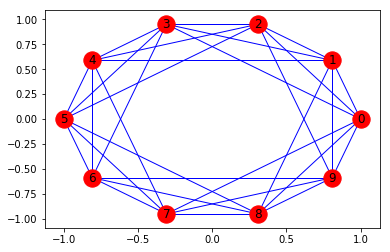

In [78]:
#user controlled variables

for p in range(0,1) : #time loop
    p = p*0.1
#     p = 1
    print("p=",p)
    for start in range(0,1) : #initial condition loop
        start = start*0.1
#         start = 1
        print("start=",start)
        for p_rew in range(0,1) : #probability of rewiring loop
            p_rew = p_rew*0.1
#             p_rew = 1
            print("p_rew=",p_rew)
            
            nn = 6 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

            rho = 1   #probability of becoming susceptible after recovery
            r = 0.5    #probability of recovery when dose level drops below threshold

            N = 10   #number of individuals
            T = 10  #number of time steps

            mem_time_steps = 2 #the number of previous time steps which the individual remembers about 

            d_star = 1*np.ones((N,1),dtype=np.int32)

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

            partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
            partner = np.asarray(partner)
            print(type(partner))
            print(np.shape(partner))
            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            d_ini = np.zeros((N,mem_time_steps))
            d = 999*np.ones((N,T)) #doses
            D = 999*np.ones((N,T)) #cumulative doses
            

            #initial state of individuals
            #MEHTODOLOGICALY grouping into i, s or r
            #this is to make a local fraction of the population infected initially
            #previously, random parts/nodes of the population were infected intially 

            infec = np.arange(0,np.int32(start*N),1) #radnomly infecting few individuals as initial condition
            # np.random.shuffle(infec)
            infec = np.asarray(infec).reshape(np.int32(start*N),1)
            if start != 0 :
                indi_state[infec[:,0],0] = 2

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N

            #implementing marc's initial condition
            I = np.where(indi_state[:,0]==2)
            I = np.transpose(np.asarray(I))

            if len(I) != 0 :
                for i in range(0,len(I)) : 
                    d_ini[I[i],0:] = p
            else :
                d_ini[:,0:] = 0
            
            #creating the static network
            G, adj_mat, glist = static_network(N,nn,p_rew) #calling the function to create the static network
#             print(adj_mat)
            nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
            print(glist)
            for k in range(1,T): #loop for time
#                 print('k = ',k)
                d, partner = interaction(N,k,adj_mat,indi_state,d,p,glist,partner) #calling the interaction function
                upd_cumu(k,mem_time_steps,d,d_ini) #calling the fucntions to obtain and update cumulative dose
                upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
#             print(phi)
            phi_star = sum(phi[0,k-5:k])/5 #obtaining average phi_star of the last 100 time steps
            print("phi_star=",phi_star)

            f.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,phi_star))
            f.flush()

In [ ]:
%timeit interaction(N,k,adj_mat,indi_state,d,p,glist)
%timeit upd_cumu(k,mem_time_steps,d,d_ini)
%timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)
%timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)

In [ ]:
a = np.loadtxt("epid_p_phiini_prewphi_star_data.txt")[:,0]
b =  np.loadtxt("epid_p_phiini_prewphi_star_data.txt")[:,1]
c =  np.loadtxt("epid_p_phiini_prewphi_star_data.txt")[:,2]
d = np.loadtxt("epid_p_phiini_prewphi_star_data.txt")[:,3]

# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x= a.transpose(),  # <-- Put your data instead
    y= b.transpose(),  # <-- Put your data instead
    z= c.transpose(),  # <-- Put your data instead
    mode='markers',
    marker=dict(
        size=12,
        color=d,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        colorbar = dict(title = ''),
        opacity=0.8
    )
)

# Configure the layout.
layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        title='p'),
                    yaxis = dict(
                        title=r'$phi_{ini}$'),
                    zaxis = dict(
                        title= r'$p_{rew}$'),),
                    width=700,
                    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
                    )

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

In [ ]:
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[:,3]


counter = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
#         print(k)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = 121*counter
        im = col.scatter(np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),3],s=200)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, critical threshold model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("test.svg", format="svg")
# for i in range(1, 13):
#     plt.subplot(4, 3, i)
#     j = 121*counter
#     print(j)
#     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# #     plt.colorbar()
#     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
#     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
#     plt.title('p')
#     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
#     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
#     counter = counter + 1 
